In [7]:
import dotenv
import os

dotenv.load_dotenv()

True

In [8]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in langgraph?")

[{'title': "Beginner's Guide to LangGraph: Understanding State, Nodes, and ...",
  'url': 'https://medium.com/@kbdhunga/beginners-guide-to-langgraph-understanding-state-nodes-and-edges-part-1-897e6114fa48',
  'content': "Beginner’s Guide to LangGraph: Understanding State, Nodes, and Edges — Part 1 | by Kamal Dhungana | Medium Beginner’s Guide to LangGraph: Understanding State, Nodes, and Edges — Part 1 LangGraph — State, Node and Edge Explained Mainly, we will focus on various components of LangGraph: State, Node, and Edges, and how to build a complete graph from these components. Once we understand these components, we will be able to build relatively complex LangGraph-based agents. Each node represents a specific function or operation that processes the current state. Nodes can perform computations, modify the state, or generate outputs based on the input they receive. Follow 1.2K Followers Data scientist with a passion for AI, Regularly blogging about LLM and OpenAI's innovations,Sh

In [9]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatOpenAI(model="gpt-4o-mini")
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

In [10]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [11]:
from typing import Literal

def route_tools(
    state: State,
):
    """
    마지막 메시지에 도구 호출이 있으면 ToolNode로 라우팅하기 위해 conditional_edge에서 사용한다.
    그렇지 않으면 종료로 라우팅한다.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END

graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

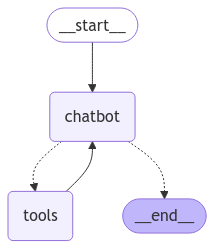

In [12]:
from IPython.display import Image, display

try:
    img = Image(graph.get_graph().draw_mermaid_png())
    display(img)
except Exception as e:
    print(f"Error displaying image: {e}")

In [15]:
def stream_graph_updates(user_input: str):
    messages = []
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            messages.append(value["messages"][-1].content)

    return "\n".join(messages)


question = "오늘 서울 날씨가 어때?"
result = stream_graph_updates(question)
print(f"result: {result}")

result: 
[{"title": "\uc11c\uc6b8\ud2b9\ubcc4\uc2dc, \uc11c\uc6b8\uc2dc, \ub300\ud55c\ubbfc\uad6d \ud604\uc7ac \ub0a0\uc528 - AccuWeather", "url": "https://www.accuweather.com/ko/kr/seoul/226081/current-weather/226081", "content": "\uc11c\uc6b8\ud2b9\ubcc4\uc2dc, \uc11c\uc6b8\uc2dc, \ub300\ud55c\ubbfc\uad6d \ud604\uc7ac \ub0a0\uc528 | AccuWeather \uc11c\uc6b8\ud2b9\ubcc4\uc2dc, \uc11c\uc6b8\uc2dc ========== 31\u00b0F \ud604\uc7ac \uc704\uce58 \uc0ac\uc6a9 \uc11c\uc6b8\ud2b9\ubcc4\uc2dc \uc11c\uc6b8\uc2dc 31\u00b0 \uc11c\uc6b8\ud2b9\ubcc4\uc2dc, \uc11c\uc6b8\uc2dc \ub0a0\uc528 \uc624\ub298 WinterCast \uc9c0\uc5ed {stormName} \ucd94\uc801\uae30 \uc2dc\uac04\ubcc4 \uc77c\ubcc4 \ub808\uc774\ub354 MinuteCast \uc6d4 \ub300\uae30\uc9c8 \uac74\uac15 \ubc0f \ud65c\ub3d9 \uc624\ub298 WinterCast \uc2dc\uac04\ubcc4 \uc77c\ubcc4 \ub808\uc774\ub354 MinuteCast \uc6d4 \ub300\uae30\uc9c8 \uac74\uac15 \ubc0f \ud65c\ub3d9 RealFeel\u00ae 36\u00b0 \ucd94\uc6c0 RealFeel Shade\u2122 32\u00b0 \ucd94\uc6c0 36\